# Effect of potential pixel scale

__last update__: 4/06/22

In [55]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
from tqdm import tqdm
import numpy as np
import pickle as pkl
import corner
import copy
import tqdm
from scipy.optimize import minimize
import seaborn as sns
import jax
import jax.numpy as jnp

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import LogNorm, TwoSlopeNorm, Normalize
plt.rc('image', interpolation='none')
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"

from herculens.Util.jax_util import WaveletTransform
from herculens.Util import plot_util

In [56]:
SAVE_FIGURES = False
figure_dir = os.path.join('figures')

In [57]:
def add_scale_bar(ax, extent, pixel_size, size_arcsec=1, bar_width_pixel=1, 
                  position=None, color='white', fontsize=16):
    if position is None:
        position = (extent[0]+5*pixel_size, extent[2]+5*pixel_size)
    width, height = size_arcsec, bar_width_pixel*pixel_size
    bar = mpatches.Rectangle(position, width, height, facecolor=color)
    ax.add_patch(bar)
    text_offset_y = 2 * height
    text = '{}"'.format(size_arcsec)
    ax.text(position[0]+width/2., position[1]+text_offset_y, text, color=color, fontsize=fontsize, 
            horizontalalignment='center', verticalalignment='bottom')
    
def add_text_box(ax, text, loc='right', fontsize=16,
                 txt_color='black', txt_alpha=1,
                 bg_color='white', bg_alpha=1):
    if loc == 'right':
        x, y = 0.95, 0.05
        ha, va = 'right', 'bottom'
    elif loc == 'left':
        x, y = 0.05, 0.05
        ha, va = 'left', 'bottom'
    elif loc == 'top left':
        x, y = 0.05, 0.95
        ha, va = 'left', 'top'
    elif loc == 'top right':
        x, y = 0.95, 0.95
        ha, va = 'right', 'top'
    ax.text(x, y, text, color=txt_color, alpha=txt_alpha, fontsize=fontsize, 
            horizontalalignment=ha, verticalalignment=va,
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': bg_alpha})

def get_model_data(scenario='real', perturbation_type='dark_halo', pixel_scale=4):
    
    filename = f'sumplot-{scenario}-{perturbation_type}-scale_{pixel_scale}-smooth_source'
    if scenario == 'real':
        filename += '-init_from_smooth'
    
    with open(os.path.join('results', filename + '.pkl'), 'rb') as f:
        data, full_lens_image, full_kwargs_result, input_kwargs_result, \
            mask_fitgrid, pixpot_noise_map, \
            pixpot_truth_highres, pixpot_truth_fitgrid, \
            _, cov_matrix_pixpot, _, _, _, _ \
            = pkl.load(f)
        
    pixpot_model = full_kwargs_result['kwargs_lens'][-1]['pixels']
    try:  # TODO: fix that
        pixpot_model_error = np.sqrt(np.abs(cov_matrix_pixpot)).reshape(*pixpot_model.shape)
    except ValueError as e:
        print("Reshaping error map assuming 5 smooth lens and 7 smooth source parameters!")
        pixpot_model_error = np.sqrt(np.abs(cov_matrix_pixpot[5:-7])).reshape(*pixpot_model.shape)

    lensed_src = full_lens_image.model(**full_kwargs_result, lens_light_add=False)
    src_snr = lensed_src / np.sqrt(full_lens_image.Noise.C_D_model(lensed_src))
    mask_highres = (src_snr > 5).astype(float)
    
    grid_class = full_lens_image.Grid
        
    return [data, full_lens_image, full_kwargs_result, pixpot_model, 
            pixpot_truth_highres, pixpot_truth_fitgrid, mask_highres, mask_fitgrid]

pixpot pixel scale: 4
beta(1) = 0.6400
beta(2) = 1.2800
beta(3) = 2.5600
beta(4) = 5.1200
pixpot pixel scale: 3
beta(1) = 0.4800
beta(2) = 0.9600
beta(3) = 1.9200
beta(4) = 3.8400
beta(5) = 7.6800
pixpot pixel scale: 2
beta(1) = 0.3200
beta(2) = 0.6400
beta(3) = 1.2800
beta(4) = 2.5600
beta(5) = 5.1200
pixpot pixel scale: 1.5
beta(1) = 0.2400
beta(2) = 0.4800
beta(3) = 0.9600
beta(4) = 1.9200
beta(5) = 3.8400
beta(6) = 7.6800


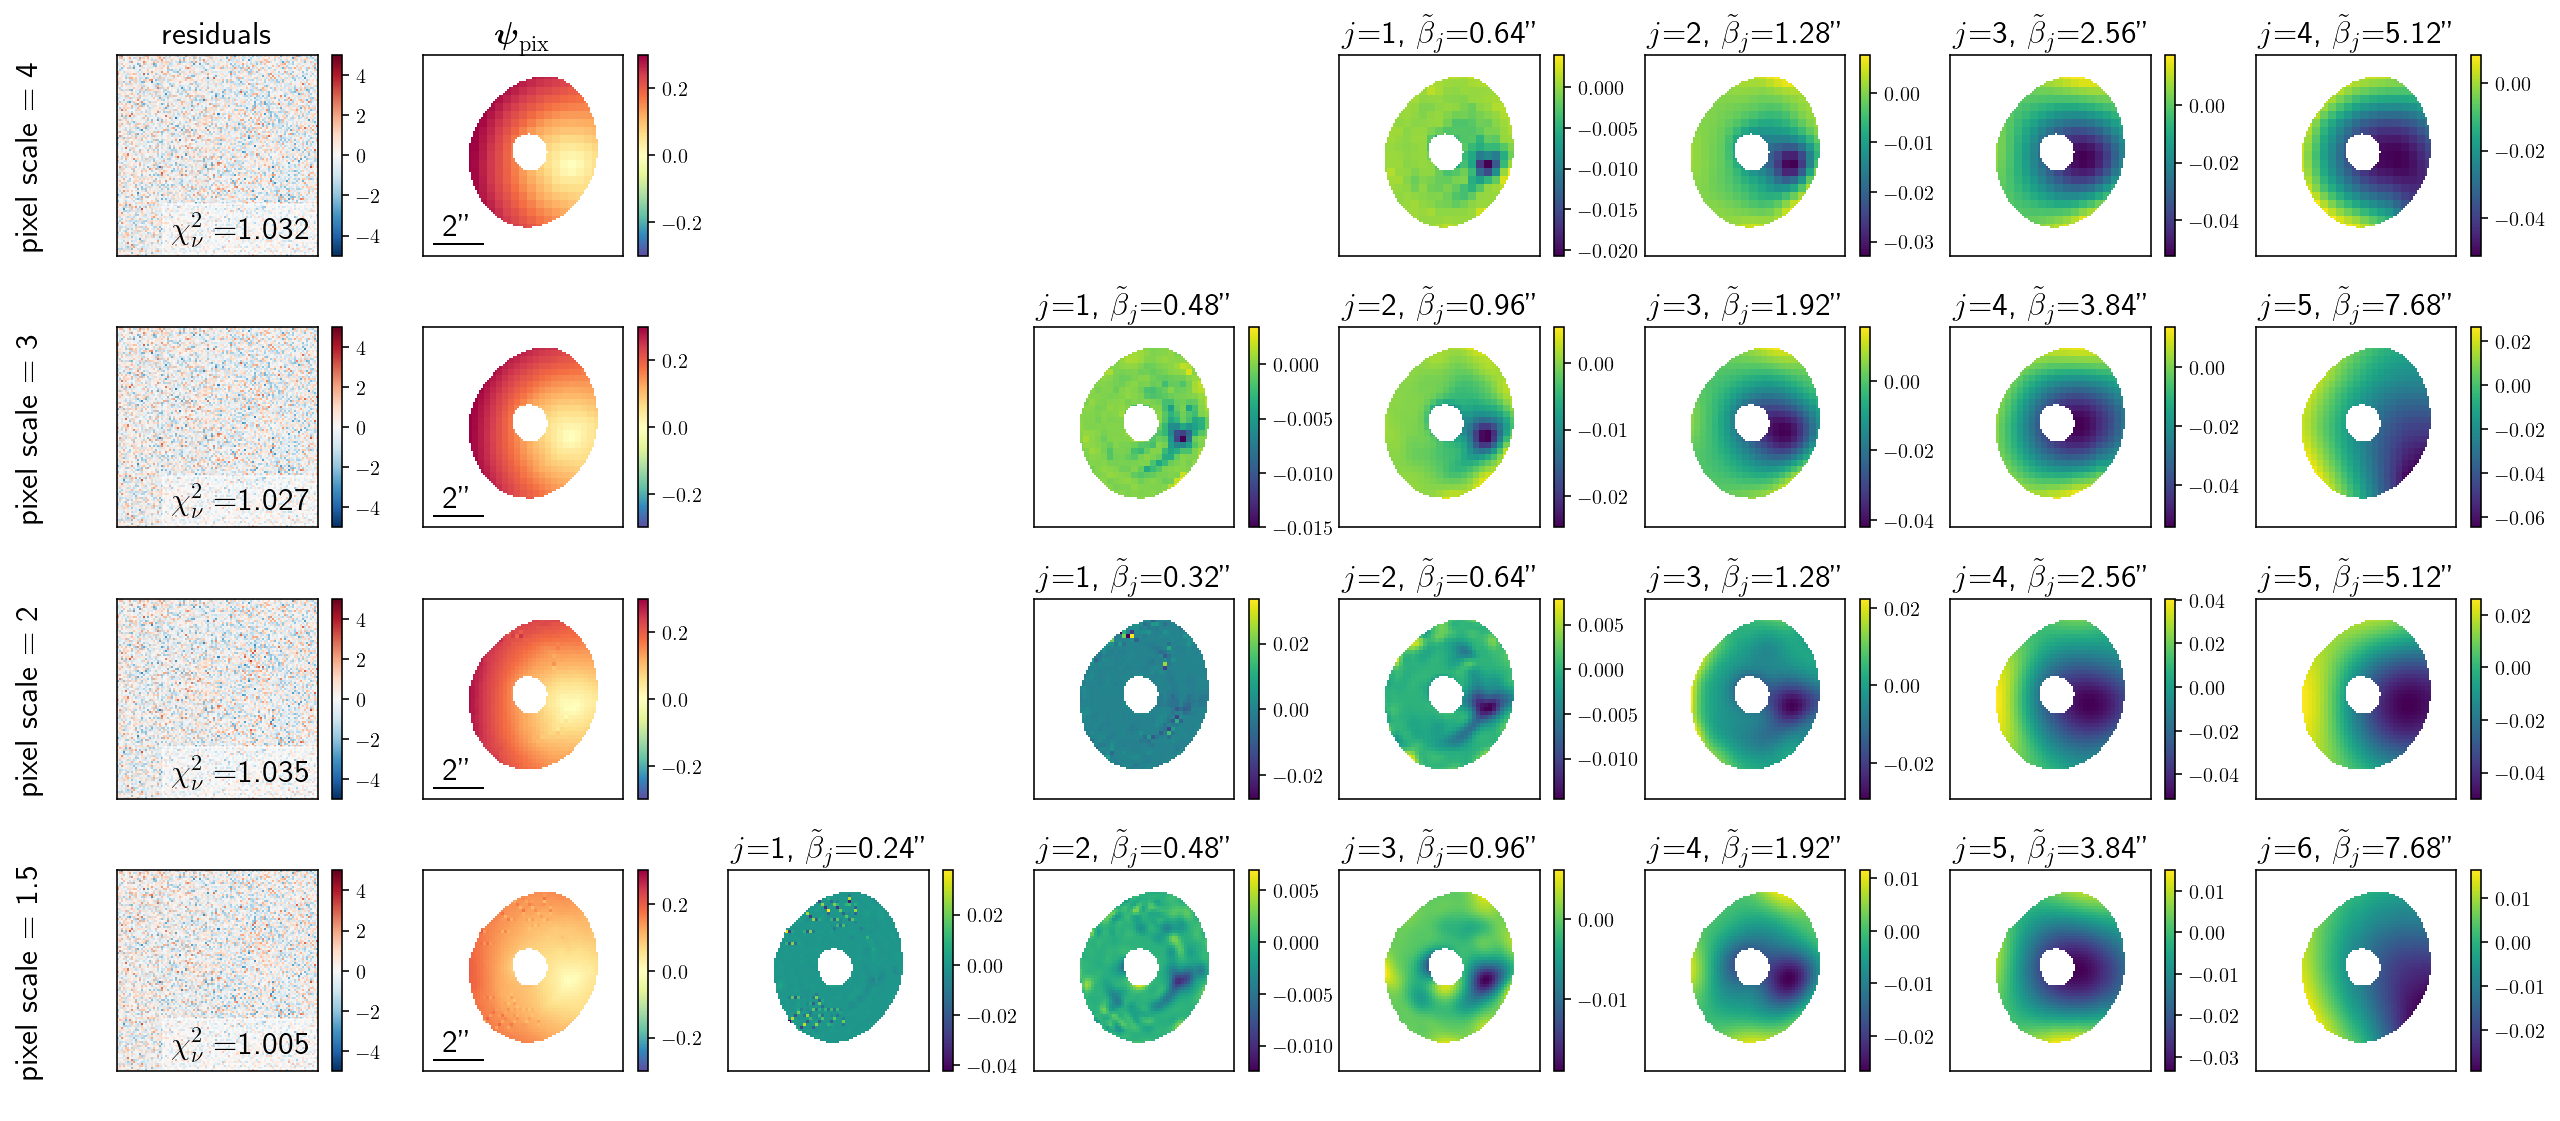

In [87]:
perturbation_type = 'dark_halo'
pixel_scale_list = [4, 3, 2, 1.5]

fontsize = 16
npix_data = data.shape[0]
max_starlet_scales = int(np.log2(npix_data // min(pixel_scale_list)))
num_cols  = 1 + 2 + max_starlet_scales
num_rows  = len(pixel_scale_list)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(22, 2.5*num_rows),
                         gridspec_kw={'width_ratios': [0.05]+[1]*(num_cols-1)})

for i, pixel_scale in enumerate(pixel_scale_list):
    print("pixpot pixel scale:", pixel_scale)
    
    model_data = get_model_data(scenario='ideal', 
                                perturbation_type=perturbation_type, 
                                pixel_scale=pixel_scale)
    data, lens_image, kwargs_results = model_data[0], model_data[1], model_data[2]
    pixpot_model = model_data[3]
    pixpot_input_highres, pixpot_input = model_data[4], model_data[5]
    pixpot_mask_highres, pixpot_mask = model_data[6], model_data[7]
    
    mask_nans = np.nan*np.ones_like(pixpot_mask_highres)
    mask_nans[pixpot_mask_highres == 0] = 1

    model = lens_image.model(**kwargs_results)
    residuals = np.array(lens_image.normalized_residuals(data, model))
    red_chi2 = lens_image.reduced_chi2(data, model)
    extent = lens_image.Grid.extent
    pix_scl = lens_image.Grid.pixel_width
    pix_scl_pixpot = pix_scl * pixel_scale
    
    # starlet transform of the potential model
    npix_pixpot = pixpot_model.shape[0]
    nscales = int(np.log2(npix_pixpot))
    starlet = WaveletTransform(nscales, wavelet_type='starlet')
    pixpot_coeffs = starlet.decompose(pixpot_model)
    assert pixpot_coeffs.shape[0]-1 == nscales
    
    k = 0 # column index
    ax = axes[i, k]
    ax.axis('off')
    ax.text(-1, 0.5, f"pixel scale = {pixel_scale}", transform=ax.transAxes, 
            ha='left', va='center', fontsize=fontsize, rotation=90)
    k += 1
    
    ax = axes[i, k]
    if i == 0: ax.set_title("residuals", fontsize=fontsize)
    ax.set_xticks([])
    ax.set_yticks([])
    im = ax.imshow(residuals, origin='lower', extent=extent, cmap='RdBu_r', norm=Normalize(-5, 5))
    im.set_rasterized(True)
    plot_util.nice_colorbar(im)
    add_text_box(ax, r"$\chi^2_\nu=$"+f"{red_chi2:.3f}", 
                 fontsize=fontsize, txt_color='black', bg_color='white', bg_alpha=0.5)
    k += 1
    
    ax = axes[i, k]
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0: ax.set_title(r"$\boldsymbol{\psi}_{\rm pix}$", fontsize=fontsize)
    pixpot_model_o = pixpot_model - pixpot_model[pixpot_mask == 1].min()
    #vmax = np.abs(pixpot_model_o).max()
    vmax = 0.3
    im = ax.imshow(pixpot_model_o, origin='lower', extent=extent, cmap='Spectral_r', norm=Normalize(-vmax, vmax))
    im.set_rasterized(True)
    plot_util.nice_colorbar(im) #, label=r"$\psi$", fontsize=fontsize)
    ax.imshow(mask_nans, origin='lower', extent=extent, cmap='gray_r')
    add_scale_bar(ax, extent, pix_scl, size_arcsec=2, bar_width_pixel=1, 
                  color='black', fontsize=fontsize)
    k += 1
    
    num_off_axes = num_cols - k - nscales
    for _ in range(num_off_axes):
        axes[i, k].axis('off')  # deactivate other axes
        k += 1
    
    for j in range(1, nscales+1):
        
        beta_j = 2**j * pix_scl_pixpot  # characteristic scale in arcsec
        print(f"beta({j}) = {beta_j:.4f}")
        
        ax = axes[i, k]
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_title(f"starlet $j$={j}", fontsize=fontsize)
        ax.set_title(f"$j$={j}, " + r"$\tilde{\beta}_j$"+f'={beta_j:.2f}"', fontsize=fontsize)
        coeffs_j = pixpot_coeffs[j-1]
        vmin = coeffs_j[pixpot_mask == 1].min()
        vmax = coeffs_j[pixpot_mask == 1].max()
        im = ax.imshow(coeffs_j, origin='lower', extent=extent, norm=Normalize(vmin, vmax))
        im.set_rasterized(True)
        ax.imshow(mask_nans, origin='lower', extent=extent, cmap='gray_r')
        plot_util.nice_colorbar(im)
        k += 1
        
#fig.tight_layout()
fig.subplots_adjust(wspace=0.4, hspace=0)
plt.show()

In [90]:
if SAVE_FIGURES:
    # saving as pdf causes weird misalignments of axes, so I save in jpg
    figure_name =  f'pixel_scale_effect-{perturbation_type}.png'
    fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight', dpi=300)